**TO DO**

- Think about visualizing and comparing the Two bands (e.g. followers, popularity, related artists)
- Add track score in barplot

**THIS NOTEBOOK:**

- Retrieve metadata at Spotify about songs - Evanescence
- Retrieve metadata at Spotify about songs - Within temptation
- Merge data retrieve from Spotify with lyrics obtained in previous notebook via web scrapping
- Some Visualization

**NEXT NOTEBOOKS:**

- NLP (sentiment analysis)
- Visualization
- Retrieve data about both bands from Twitter
- Apply Sentiment Analysis to Twitter data


REFS:

- https://developer.spotify.com/dashboard/login
- https://developer.spotify.com/documentation/web-api/reference/
- https://spotipy.readthedocs.io/en/latest/#

In this notebook I'll be using Spotify API to obtain more data about the lyrics we scrapped from the web in the last notebook. To have access to Spotify API is necessary to request you credentials at https://developer.spotify.com/dashboard/login.

I'll be using Spotipy is a lightweight Python library for the [Spotify Web API](https://developer.spotify.com/documentation/web-api/).

# Access to Spotify API 

You will need Spotify API credentials. If you don't have them yet got to https://developer.spotify.com/dashboard/login.


In [2]:
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 

try:
    import private # .py file with my credentials 
    # maybe redirect uri will be required for some of the commands 
    redirect_uri = private.redirect_uri

    # credentials
    username = private.username
    client_id=private.cid 
    client_secret=private.secret

except ModuleNotFoundError:
    import settings # have the credentials of another user
    redirect_uri = settings.redirect_uri

    # credentials
    username = settings.username
    client_id=settings.cid
    client_secret=settings.secret   
    
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


# Retrieving information about an artist

First we will use the API to retrieve information about the artist using the name of the artist. The function bellow retrieve this information and returns dictionary containing main information about the artist which includes the artist's uri. This information will be used to retrieve, for instance, information about artist's albums.

In [3]:
def find_artist_info(artist):
    
    """ Retrieve main information about an artist given artist's name which includes also name of bands.
    
    Input:
        artist : artist's name (string)
    
    Output:
        dictionary with main info about artist, including related artist. """
    
    # find artist by name and extract uri
    
    artist_uri = sp.search(q='artist:' + artist, type='artist')['artists']['items'][0]['uri']
    
    # Extract info about artist
    
    artist_info = sp.artist(artist_uri)
    
    # Obtain list of related artists. Similarity is based on analysis of the Spotify community’s listening history.

    related = sp.artist_related_artists(artist_uri)
    
    related_artists = []

    for idx in range(len(related['artists'])):
        related_artists.append(related['artists'][idx]['name'])
    
    return {'external_urls': artist_info['external_urls']['spotify'],
            'followers' : artist_info['followers']['total'],
            'id': artist_info['id'],
            'name' : artist_info['name'],
            'genres': ', '.join(artist_info['genres']),
            'popularity' : artist_info['popularity'],
            'related_artists': ', '.join(related_artists),
            'uri': artist_uri}
    

In [4]:
info_evanescence = find_artist_info('evanescence')
info_evanescence

{'external_urls': 'https://open.spotify.com/artist/5nGIFgo0shDenQYSE0Sn7c',
 'followers': 2540017,
 'id': '5nGIFgo0shDenQYSE0Sn7c',
 'name': 'Evanescence',
 'genres': 'alternative metal, post-grunge',
 'popularity': 76,
 'related_artists': 'Amy Lee, We Are The Fallen, Within Temptation, Flyleaf, Lacuna Coil, Delain, Seether, Epica, Apocalyptica, Tarja, The Rasmus, In This Moment, Halestorm, Nightwish, Red, Hoobastank, Three Days Grace, The Pretty Reckless, 3 Doors Down, Sirenia',
 'uri': 'spotify:artist:5nGIFgo0shDenQYSE0Sn7c'}

In [5]:
info_within_temptation = find_artist_info('within temptation')
info_within_temptation

{'external_urls': 'https://open.spotify.com/artist/3hE8S8ohRErocpkY7uJW4a',
 'followers': 741519,
 'id': '3hE8S8ohRErocpkY7uJW4a',
 'name': 'Within Temptation',
 'genres': 'dutch metal, gothic metal, gothic symphonic metal, power metal, symphonic metal',
 'popularity': 68,
 'related_artists': "Leaves' Eyes, Delain, Epica, Tarja, Visions of Atlantis, Nemesea, Sirenia, Lunatica, Tristania, Theatre Of Tragedy, Amberian Dawn, After Forever, Xandria, Lacuna Coil, Edenbridge, Nightwish, Stream of Passion, Krypteria, Therion, We Are The Fallen",
 'uri': 'spotify:artist:3hE8S8ohRErocpkY7uJW4a'}

## Which related artists Evanescence and Within Temptation have in common considering the listeners of Spotify?

In [6]:
set(info_evanescence['related_artists'].split(',')).intersection(set(set(info_within_temptation['related_artists'].split(','))))

{' Delain',
 ' Epica',
 ' Lacuna Coil',
 ' Nightwish',
 ' Sirenia',
 ' Tarja',
 ' We Are The Fallen'}

So we can say that people that like `Evanescence` and `Within Temptation` also appreciate Apocalyptica, Delain, Epica, Lacuna Coil, Nightwish, Sirenia, and Tarja. In a recommender system point of view we could recommend people to explore this bands ;-)

# Artist top tracks

In [7]:
import pandas as pd

def top_tracks_by_country(artist_uri, country = 'US'):
    """ Get Spotify catalog information about an artist’s top 10 tracks by country. """
    
    track_name = []
    track_id = []
    track_popularity = []

    top = sp.artist_top_tracks(artist_uri, country = country)
    
    for idx in range(len(top['tracks'])):
        track_name.append(top['tracks'][idx]['name'])
        track_id.append(top['tracks'][idx]['id'])
        track_popularity.append(top['tracks'][idx]['popularity'])
        
    dict_top = {'track_id': track_id,
               'track_name': track_name,
               'track_popularity': track_popularity}
        
    df = pd.DataFrame(dict_top)
    
    return df

In [8]:
evanescence_uri = info_evanescence['uri']
df_evanescence_US = top_tracks_by_country(evanescence_uri)
df_evanescence_US

,track_id,track_name,track_popularity
0,0COqiPhxzoWICwFCS4eZcp,Bring Me To Life,77
1,4UzVcXufOhGUwF56HT7b8M,My Immortal,73
2,3UygY7qW2cvG9Llkay6i1i,Going Under,68
3,663Karu2rvKLdnY0eo1n3M,Call Me When You're Sober,64
4,0tWEB6BxbI48XN79QE1JbT,Everybody's Fool,62
5,5YaLFRpqpUzgLLDcukNn0H,Lithium,60
6,0aYUqsvZG7bAslrUkd9Z0g,Hello,57
7,46fyLy4W9HhAkcb67kLaAV,Tourniquet,56
8,6Z77oDcn6iI1MHFCBPjl24,Haunted,54
9,5j7gLuOsBOyqooruGxX4nx,Taking Over Me,54


In [9]:
df_evanescence_NL = top_tracks_by_country(evanescence_uri, country='NL')
df_evanescence_NL

,track_id,track_name,track_popularity
0,0COqiPhxzoWICwFCS4eZcp,Bring Me To Life,77
1,4UzVcXufOhGUwF56HT7b8M,My Immortal,73
2,3UygY7qW2cvG9Llkay6i1i,Going Under,68
3,663Karu2rvKLdnY0eo1n3M,Call Me When You're Sober,64
4,0tWEB6BxbI48XN79QE1JbT,Everybody's Fool,62
5,5YaLFRpqpUzgLLDcukNn0H,Lithium,60
6,0aYUqsvZG7bAslrUkd9Z0g,Hello,57
7,46fyLy4W9HhAkcb67kLaAV,Tourniquet,56
8,6Z77oDcn6iI1MHFCBPjl24,Haunted,54
9,5j7gLuOsBOyqooruGxX4nx,Taking Over Me,54


In [10]:
df_evanescence_US.equals(df_evanescence_NL)

True

Both countries have the same top 10 for Evanescence. And what about withing Temptation?

In [11]:
within_temptation_uri = info_within_temptation['uri']

In [12]:
df_within_temptation_US = top_tracks_by_country(within_temptation_uri)
df_within_temptation_NL = top_tracks_by_country(within_temptation_uri, country = 'NL')
df_within_temptation_US.equals(df_within_temptation_NL)

False

It seems that the taste of americans and dutchs differ when we talk about Within Temptation. Let's see which one are the top 10 in both countries.

In [13]:
df_within_temptation_US

,track_id,track_name,track_popularity
0,6XnPopwCZ6odHVVqMsllL5,The Reckoning,56
1,4BhqnM5lktowwfHqq2JYhg,All I Need,56
2,3TEwbiC0GhIRStn3Eabtu7,Angels,55
3,15z9QEJOBV6hDdWsdZwDKP,Stand My Ground,55
4,4GBbBy05LoSveNxjKxj26m,Supernova,54
5,5oX5jpeZsXBWEheqE0qqqD,Faster,52
6,66wcihY2Y8ZSqux6EivMWa,What Have You Done (feat. Keith Caputo),53
7,7fm01f9fZNeQCYedC2xhcF,Paradise (What About Us?) [feat. Tarja],40
8,5uDWqYSiWqWTXK9CbAKIA8,Endless War,51
9,17AtQU2FNV14jSGpPfhejn,Memories,50


In [14]:
df_within_temptation_NL

,track_id,track_name,track_popularity
0,6XnPopwCZ6odHVVqMsllL5,The Reckoning,56
1,4BhqnM5lktowwfHqq2JYhg,All I Need,56
2,3TEwbiC0GhIRStn3Eabtu7,Angels,55
3,15z9QEJOBV6hDdWsdZwDKP,Stand My Ground,55
4,4GBbBy05LoSveNxjKxj26m,Supernova,54
5,28HX0PibeXSL6cfAsvwSgD,Faster,54
6,66wcihY2Y8ZSqux6EivMWa,What Have You Done (feat. Keith Caputo),53
7,2Sp8T3BrAHQmWwl9jLexDF,Paradise (What About Us?) [feat. Tarja],52
8,5uDWqYSiWqWTXK9CbAKIA8,Endless War,51
9,17AtQU2FNV14jSGpPfhejn,Memories,50


At the end both country like the same songs. However, Faster and Paradise score better in popularity in The Netherlands.

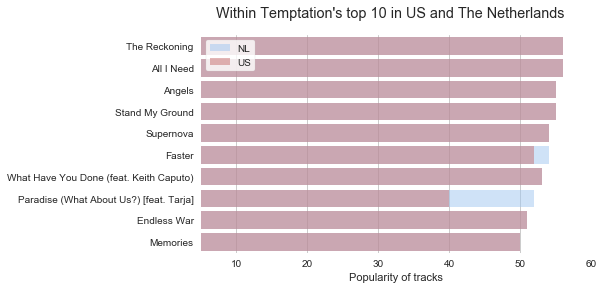

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(7, 4))

# Plot top 10 in NL
sns.set_color_codes("pastel")
sns.barplot(x="track_popularity", y="track_name", data=df_within_temptation_NL,
            label="NL", color="b", alpha = 0.5)

# Plot top 10 in US
sns.set_color_codes("muted")
sns.barplot(x="track_popularity", y="track_name", data=df_within_temptation_US,
            label="US", color="r", alpha = 0.5)

# Add a legend and informative axis label
f.suptitle("Within Temptation's top 10 in US and The Netherlands")
ax.legend(ncol=1, loc="upper left", frameon=True)
ax.set(xlim=(5, 60), ylabel="",
       xlabel="Popularity of tracks")
sns.despine(left=True, bottom=True)




**Popularity:** Track's popularity has a value between 0 and 100, with 100 being the most popular. It is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.

source: https://developer.spotify.com/documentation/web-api/reference/artists/get-artists-top-tracks/

Curious to hear snippets of the top 10? Let's include `preview url` to above dataframes so you can have a taste ;-)

In [20]:
import sys
import pandas as pd
# import streamlit as st
pd.set_option('display.max_colwidth', 0)
from IPython.display import Image, HTML

def insert_preview_url(df, track_id_list):
    """ Insert column with clickable link to snippet (30 seconds sample of a song) of songs."""
    
    list_preview_url = []

    for track_id in track_id_list:
        list_preview_url.append(sp.track(track_id)['preview_url'])
        
    df['preview_url'] = list_preview_url
    
    def make_clickable(val):
        if val is None:
            return 'No preview available'
        else:
            return '<a target="_blank" href="{}">{}</a>'.format(val, val)

    df = df.style.format({'preview_url': make_clickable})
    
    return df

In [22]:
# Updated dataframe with top 10 of Evanescence in The Netherlands

df = df_evanescence_NL
track_id_list = df_evanescence_NL['track_id']

df_evanescence_NL_preview = insert_preview_url(df, track_id_list)
df_evanescence_NL_preview

,track_id,track_name,track_popularity,preview_url
0,0COqiPhxzoWICwFCS4eZcp,Bring Me To Life,77,No preview available
1,4UzVcXufOhGUwF56HT7b8M,My Immortal,73,No preview available
2,3UygY7qW2cvG9Llkay6i1i,Going Under,68,No preview available
3,663Karu2rvKLdnY0eo1n3M,Call Me When You're Sober,64,No preview available
4,0tWEB6BxbI48XN79QE1JbT,Everybody's Fool,62,No preview available
5,5YaLFRpqpUzgLLDcukNn0H,Lithium,60,No preview available
6,0aYUqsvZG7bAslrUkd9Z0g,Hello,57,No preview available
7,46fyLy4W9HhAkcb67kLaAV,Tourniquet,56,No preview available
8,6Z77oDcn6iI1MHFCBPjl24,Haunted,54,No preview available
9,5j7gLuOsBOyqooruGxX4nx,Taking Over Me,54,No preview available


In [21]:
# Updated dataframe with top 10 of Within Temptation in The Netherlands

df = df_within_temptation_NL
track_id_list = df_within_temptation_NL['track_id']

df_within_temptation_NL_preview = insert_preview_url(df, track_id_list)
df_within_temptation_NL_preview

,track_id,track_name,track_popularity,preview_url
0,6XnPopwCZ6odHVVqMsllL5,The Reckoning,56,No preview available
1,4BhqnM5lktowwfHqq2JYhg,All I Need,56,https://p.scdn.co/mp3-preview/613509e6725e4792adb26010c84bad6eae562b44?cid=63a77ff40e794a12ae216a18befde98c
2,3TEwbiC0GhIRStn3Eabtu7,Angels,55,https://p.scdn.co/mp3-preview/1dbf69a32db3b4d23f0311f2bfbd2afd40bfbfdf?cid=63a77ff40e794a12ae216a18befde98c
3,15z9QEJOBV6hDdWsdZwDKP,Stand My Ground,55,https://p.scdn.co/mp3-preview/86774c051d057643a6daaa1b1fdbdca0e2f7c2fc?cid=63a77ff40e794a12ae216a18befde98c
4,4GBbBy05LoSveNxjKxj26m,Supernova,54,No preview available
5,28HX0PibeXSL6cfAsvwSgD,Faster,54,https://p.scdn.co/mp3-preview/dbdeec5d31a3582fc06355d9c24d4fc49e7df7f7?cid=63a77ff40e794a12ae216a18befde98c
6,66wcihY2Y8ZSqux6EivMWa,What Have You Done (feat. Keith Caputo),53,https://p.scdn.co/mp3-preview/4969cdbad38904f03074b30f4a176c6c4408235c?cid=63a77ff40e794a12ae216a18befde98c
7,2Sp8T3BrAHQmWwl9jLexDF,Paradise (What About Us?) [feat. Tarja],52,https://p.scdn.co/mp3-preview/a359f9e3b8d97551260d6d0205ddf9d2edbe76c6?cid=63a77ff40e794a12ae216a18befde98c
8,5uDWqYSiWqWTXK9CbAKIA8,Endless War,51,No preview available
9,17AtQU2FNV14jSGpPfhejn,Memories,50,https://p.scdn.co/mp3-preview/5273e1ffb4bde07151663d8320a9a0235bb99a00?cid=63a77ff40e794a12ae216a18befde98c


Unfortunately, Spotify don't provide snippets for all songs. Bad surprise that no songs in the top 10 have no snippets. A shame...

# Retrieving album's information

Now that we can retrieve among other information the artist's uri we are able to retrieve information about artist's albums. The following function was construct so relevant information about albums are retrieved and stored in a .csv file.

In [26]:
import pandas as pd

def retrieving_albums_info(artist_uri, file_name, limit = 50, max_nr_albums=2000):
    """ 
    Retrieve albums information of a given artist_uri.
    
    Input:
        artist_uri : The Spotify URI for the artist.
        file_name: name of the .csv that will have the information retrieved
        
    Output:
        csv file with album information of a chosen artist
    
    
    """
    
    album_name = []
    album_id = []
    album_type = []
    artists = []
    release_date = []
    # release_date_precision = []
    cover_album = []
    total_tracks = []
    available_markets = []
    total_available_markets = []
    uri = []

    for i in range(0,max_nr_albums,50):
        albums_per_artist = sp.artist_albums(artist_uri, limit=limit, offset=i)
        for album in range(len(albums_per_artist['items'])):
            album_name.append(albums_per_artist['items'][album]['name'])
            album_id.append(albums_per_artist['items'][album]['id'])
            album_type.append(albums_per_artist['items'][album]['album_type'])
            artists.append(albums_per_artist['items'][album]['artists'][0]['name'])
            release_date.append(albums_per_artist['items'][album]['release_date'])
    #         release_date_precision.append(albums_per_artist['items'][album]['release_date_precision'])
            cover_album.append(albums_per_artist['items'][album]['images'][0]['url'])
            total_tracks.append(albums_per_artist['items'][album]['total_tracks'])
            available_markets.append(','.join(albums_per_artist['items'][album]['available_markets']))
            total_available_markets.append(len(albums_per_artist['items'][album]['available_markets']))
        
            uri.append(albums_per_artist['items'][album]['uri'])

    dict_albums = {'album_name':album_name,
                   'album_id': album_id,
                   'album_type' : album_type,
                   'artists': artists,
                   'release_date' : release_date,
    #                'release_date_precision' : release_date_precision,
                   'cover_album':cover_album,
                   'total_tracks':total_tracks,
                   'available_markets': available_markets,
                   'total_available_markets':total_available_markets,
                  'uri': uri}

    # creating dataframe

    df = pd.DataFrame(dict_albums)

    # dropping duplicates based on album_name and release_date

    df.drop_duplicates(subset=['album_name','release_date'], keep = 'first', inplace = True)
    
    # reset index
    
    df.reset_index(inplace = True)
    
    # Create year column
    
    df['release_date'] = pd.to_datetime(df['release_date'],  format='%Y-%m-%d')
    
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    
    # Ordering
    
    df = df[['album_id', 'album_name', 'album_type', 'artists', 'release_year','release_date', 'cover_album',
            'total_tracks','available_markets','total_available_markets', 'uri']]

    # saving result in csv

    df.to_csv("./data/"+file_name)
    
    return df


In [32]:
artist_uri = info_evanescence['uri']
artist_uri

'spotify:artist:5nGIFgo0shDenQYSE0Sn7c'

In [33]:
df_albums_evanescence

,album_id,album_name,album_type,artists,release_year,release_date,cover_album,total_tracks,available_markets,total_available_markets,uri
0,12NBjimNnuWAP0OXIlwyrZ,Synthesis Live,album,Evanescence,2018,2018-12-14,https://i.scdn.co/image/ab67616d0000b273d7d7b2503d4ac3964cc87a5b,16,"AD,AE,AT,AU,BE,BG,BH,CH,CY,CZ,DE,DK,DZ,EE,EG,ES,FI,FR,GB,GR,HK,HU,ID,IE,IL,IN,IS,IT,JO,KW,LB,LI,LT,LU,LV,MA,MC,MT,MY,NL,NO,NZ,OM,PH,PL,PT,QA,RO,SA,SE,SG,SK,TH,TN,TR,TW,VN,ZA",58,spotify:album:12NBjimNnuWAP0OXIlwyrZ
1,3kWy3ooh6m3BPzGHfT5mte,Synthesis,album,Evanescence,2017,2017-11-10,https://i.scdn.co/image/ab67616d0000b27369c402625e586216ddd850c8,16,"AU,EG,HK,ID,IN,MY,NZ,PH,SG,TH,TW,VN",12,spotify:album:3kWy3ooh6m3BPzGHfT5mte
2,78S8Z3EOl7hbzePSH4GQyF,Synthesis,album,Evanescence,2017,2017-11-08,https://i.scdn.co/image/ef1c21ca628a5f82986728a14c9b54949c189060,16,JP,1,spotify:album:78S8Z3EOl7hbzePSH4GQyF
3,55VNOaV0zcQqGSrjOBHKVG,Lost Whispers,album,Evanescence,2016,2016-01-01,https://i.scdn.co/image/5cc5773196912b58bb4d0ff434ad879f09898818,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:55VNOaV0zcQqGSrjOBHKVG
4,3U85Q4GtR0I3VwgDOKHttO,Evanescence,album,Evanescence,2011,2011-01-01,https://i.scdn.co/image/660b8cc102ad45e105f8c591c7175bf96534ad01,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:3U85Q4GtR0I3VwgDOKHttO
...,...,...,...,...,...,...,...,...,...,...,...
72,65HdXCLpwIXZGt7kQe3bK6,Midnight Diaries,compilation,Various Artists,2010,2010-01-01,https://i.scdn.co/image/798538bdf6f3c63af2c198bcfecbea8b1311685c,36,MX,1,spotify:album:65HdXCLpwIXZGt7kQe3bK6
73,0anDTe9W7YJ82hIpJCsYft,iMusic1 Rocks,compilation,Various Artists,2009,2009-08-28,https://i.scdn.co/image/ab67616d0000b2733593d27a32a55026f41e493e,39,"AT,CH,DE",3,spotify:album:0anDTe9W7YJ82hIpJCsYft
74,5jc6tOSK9BpocWWQgFo8Md,ThriveMix Presents: DanceAnthems 2,compilation,Various Artists,2008,2008-01-01,https://i.scdn.co/image/44519ed0f23972ba24982c16019e587002350c5d,16,US,1,spotify:album:5jc6tOSK9BpocWWQgFo8Md
75,7soKb31c9JTxBllcJ0J2KT,Now! 12,compilation,Various Artists,2007,2007-01-01,https://i.scdn.co/image/91dfccfbd04e0fa65584890f7a28b4d425b391cf,18,CA,1,spotify:album:7soKb31c9JTxBllcJ0J2KT


In [36]:
df_albums_evanescence.sort_values(by='release_year', ascending=False)

,album_id,album_name,album_type,artists,release_year,release_date,cover_album,total_tracks,available_markets,total_available_markets,uri
23,53RP1ZPLTpJ2HHsSr6od6S,Sad Songs Sing-Along,compilation,Various Artists,2020,2020-01-03,https://i.scdn.co/image/c376ebd55a35f63c8df65d1d65ca7105a9564b5d,20,"AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JP,KW,LB,LT,LU,LV,MA,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TR,TW,US,UY,VN,ZA",73,spotify:album:53RP1ZPLTpJ2HHsSr6od6S
22,7H1kjRJpRaBEiby6nOgrkz,Sad Music,album,Various Artists,2020,2020-01-03,https://i.scdn.co/image/3fb8b0ddec1ac95f6c886ce720332ee1ea28cda6,29,"AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JP,KW,LB,LT,LU,LV,MA,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TR,TW,US,UY,VN,ZA",73,spotify:album:7H1kjRJpRaBEiby6nOgrkz
21,0x8eHYxy44gViOqnOSEg9m,Nostalgia 2000's,compilation,Various Artists,2020,2020-01-03,https://i.scdn.co/image/a00c937d52adbdf30460a6b40f960fb11e430333,36,"AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JP,KW,LB,LT,LU,LV,MA,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TR,TW,US,UY,VN,ZA",73,spotify:album:0x8eHYxy44gViOqnOSEg9m
20,0IpuHl2S3rACtra5VzOfFr,2000's Nostalgia,compilation,Various Artists,2020,2020-01-31,https://i.scdn.co/image/ab67616d0000b27351a008a4adfb33a63ba67825,34,"AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JP,KW,LB,LT,LU,LV,MA,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TR,TW,US,UY,VN,ZA",73,spotify:album:0IpuHl2S3rACtra5VzOfFr
38,4jjp8jYxe3krFYeOnJxfNx,Monster Millennium Hits,album,Various Artists,2019,2019-10-25,https://i.scdn.co/image/ab67616d0000b273c31a6fc1b8d4545d07ad9d80,20,"AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JP,KW,LB,LT,LU,LV,MA,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TR,TW,US,UY,VN,ZA",73,spotify:album:4jjp8jYxe3krFYeOnJxfNx
...,...,...,...,...,...,...,...,...,...,...,...
75,7soKb31c9JTxBllcJ0J2KT,Now! 12,compilation,Various Artists,2007,2007-01-01,https://i.scdn.co/image/91dfccfbd04e0fa65584890f7a28b4d425b391cf,18,CA,1,spotify:album:7soKb31c9JTxBllcJ0J2KT
6,3lFQ9ihSNR5YD0yi0yTzdC,The Open Door,album,Evanescence,2006,2006-01-01,https://i.scdn.co/image/bd3cdbd88ea146ba5bcc31738ae34471a7bc22a9,13,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:3lFQ9ihSNR5YD0yi0yTzdC
76,5oi50Gv8yvqAqPbWDdZhYA,Elektra: The Album,compilation,Various Artists,2005,2005-01-01,https://i.scdn.co/image/9a8a5765f320549f0276ff5df8f9a11f1f4c9719,15,US,1,spotify:album:5oi50Gv8yvqAqPbWDdZhYA
7,5SpQ4sf9sXFWHgUKYCZSDF,Anywhere But Home (Live),album,Evanescence,2004,2004-01-01,https://i.scdn.co/image/baa1db3acd78e252289618513899945055075ea5,14,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:5SpQ4sf9sXFWHgUKYCZSDF


Before applying some filtering, I'll check if there were some single or album release these last 2 years by Evanescence.

In [43]:
df_albums_evanescence[(df_albums_evanescence['release_year']>=2019) & (df_albums_evanescence['artists']=='Evanescence')]

,album_id,album_name,album_type,artists,release_year,release_date,cover_album,total_tracks,available_markets,total_available_markets,uri
9,053OECifPxrpiOKbiaP5Nm,The Chain,single,Evanescence,2019,2019-11-22,https://i.scdn.co/image/0123256dd623e1e33af9f783b6b6aca01c491e0b,1,"AD,AE,AT,AU,BE,BG,BH,CH,CY,CZ,DE,DK,DZ,EE,EG,ES,FI,FR,GB,GR,HK,HU,ID,IE,IL,IN,IS,IT,JO,KW,LB,LI,LT,LU,LV,MA,MC,MT,MY,NL,NO,NZ,OM,PH,PL,PT,QA,RO,SA,SE,SG,SK,TH,TN,TR,TW,VN,ZA",58,spotify:album:053OECifPxrpiOKbiaP5Nm
10,06lCOYQj86ep2FQ5E7zfJg,The Chain (From Gears 5),single,Evanescence,2019,2019-11-22,https://i.scdn.co/image/484521305e709ebc0e19f299ce3a8baece2ef356,1,JP,1,spotify:album:06lCOYQj86ep2FQ5E7zfJg
11,1QgqZD9a32WpKpVQjmfCZO,"The Chain (From ""Gears 5"")",single,Evanescence,2019,2019-11-22,https://i.scdn.co/image/3df44929730d9c0f32da0d20ea82715ce48fce86,1,"AR,BO,BR,CA,CL,CO,CR,DO,EC,GT,HN,MX,NI,PA,PE,PY,SV,US,UY",19,spotify:album:1QgqZD9a32WpKpVQjmfCZO


In [45]:
df_albums_evanescence[(df_albums_evanescence['release_year']>=2019) & (df_albums_evanescence['artists']=='Evanescence')].iloc[0]

album_id                   053OECifPxrpiOKbiaP5Nm                                                                                                                                                       
album_name                 The Chain                                                                                                                                                                    
album_type                 single                                                                                                                                                                       
artists                    Evanescence                                                                                                                                                                  
release_year               2019                                                                                                                                                                     

In [51]:
single_ID = df_albums_evanescence[(df_albums_evanescence['release_year']>=2019) & (df_albums_evanescence['artists']=='Evanescence')].iloc[0]['album_id']

Let's filter albums that are not of type compilation or single. First, compilations usually include tracks of other artists. Second, singles are usually included later in an album. Observe, that  in the dataframe above there are albums that should be classified as `compilation` (artists: Various Artists) but are still classified as `album`. Therefore, we will filter out `album_type` compilation and single, and `artists` Various Artists.

After all the filtering, a list of id of these albums will be created so we will use it to retrieve information about albums' tracks.

I'll include to this list the id of the newest single since we do not know when a new album will be released.

In [46]:
df_albums_evanescence_filtered = df_albums_evanescence.copy()

# only albums of type 'album' and from artist 'eva'
df_albums_evanescence_filtered = df_albums_evanescence_filtered[(df_albums_evanescence_filtered['album_type']=='album')
                                                                &(df_albums_evanescence_filtered['artists']=='Evanescence')]

# organize by album's release date
df_albums_evanescence_filtered = df_albums_evanescence_filtered.sort_values(by='release_year')

# reset index
df_albums_evanescence_filtered.reset_index(inplace=True, drop = True)

In [47]:
df_albums_evanescence_filtered.shape

(9, 11)

Initially, we retrieved 77 albums. After, filtering we kept 9 albums which are not single or compilation. Notice that two of them have repeated entries. Album `Evanescence` have two versions where the Deluxe version has more tracks. On the other side, album `Synthesis` has also two versions (studio and Live). However, they have the same number of tracks. There is also another entry for `Synthesis` for the studio version with a different release date. Apparently, in Japan this album was released 2 days after the other countries. Because album `Synthesis` seems to differ only on the release date we will apply another filtering to eliminate this case. 

In [48]:
df_albums_evanescence_filtered.drop_duplicates(subset=['album_name','release_year','total_tracks'], keep='first', inplace = True)

In [49]:
df_albums_evanescence_filtered.reset_index(inplace=True, drop=True)
df_albums_evanescence_filtered

,album_id,album_name,album_type,artists,release_year,release_date,cover_album,total_tracks,available_markets,total_available_markets,uri
0,02w1xMzzdF2OJxTeh1basm,Fallen,album,Evanescence,2003,2003-01-01,https://i.scdn.co/image/25d08410eb1e3cadc3834f6de7dfed6bc8e277be,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:02w1xMzzdF2OJxTeh1basm
1,5SpQ4sf9sXFWHgUKYCZSDF,Anywhere But Home (Live),album,Evanescence,2004,2004-01-01,https://i.scdn.co/image/baa1db3acd78e252289618513899945055075ea5,14,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:5SpQ4sf9sXFWHgUKYCZSDF
2,3lFQ9ihSNR5YD0yi0yTzdC,The Open Door,album,Evanescence,2006,2006-01-01,https://i.scdn.co/image/bd3cdbd88ea146ba5bcc31738ae34471a7bc22a9,13,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:3lFQ9ihSNR5YD0yi0yTzdC
3,3U85Q4GtR0I3VwgDOKHttO,Evanescence,album,Evanescence,2011,2011-01-01,https://i.scdn.co/image/660b8cc102ad45e105f8c591c7175bf96534ad01,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:3U85Q4GtR0I3VwgDOKHttO
4,0CHgu3JbE3Y0XQSejmQqLU,Evanescence (Deluxe Version),album,Evanescence,2011,2011-01-01,https://i.scdn.co/image/660b8cc102ad45e105f8c591c7175bf96534ad01,16,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:0CHgu3JbE3Y0XQSejmQqLU
5,55VNOaV0zcQqGSrjOBHKVG,Lost Whispers,album,Evanescence,2016,2016-01-01,https://i.scdn.co/image/5cc5773196912b58bb4d0ff434ad879f09898818,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:55VNOaV0zcQqGSrjOBHKVG
6,3kWy3ooh6m3BPzGHfT5mte,Synthesis,album,Evanescence,2017,2017-11-10,https://i.scdn.co/image/ab67616d0000b27369c402625e586216ddd850c8,16,"AU,EG,HK,ID,IN,MY,NZ,PH,SG,TH,TW,VN",12,spotify:album:3kWy3ooh6m3BPzGHfT5mte
7,12NBjimNnuWAP0OXIlwyrZ,Synthesis Live,album,Evanescence,2018,2018-12-14,https://i.scdn.co/image/ab67616d0000b273d7d7b2503d4ac3964cc87a5b,16,"AD,AE,AT,AU,BE,BG,BH,CH,CY,CZ,DE,DK,DZ,EE,EG,ES,FI,FR,GB,GR,HK,HU,ID,IE,IL,IN,IS,IT,JO,KW,LB,LI,LT,LU,LV,MA,MC,MT,MY,NL,NO,NZ,OM,PH,PL,PT,QA,RO,SA,SE,SG,SK,TH,TN,TR,TW,VN,ZA",58,spotify:album:12NBjimNnuWAP0OXIlwyrZ


In [50]:
df_albums_evanescence_filtered.shape

(8, 11)

At this point we have 8 albums and we are still keeping the two versions of `Evanescence` and `Synthesis`. Any repeated tracks will be eliminated later. Now we use the `album_id` of these 8 albums and the last single, `The Chain` to retrieve their tracks.

In [53]:
# creating a list with albums ids based on the last dataframe

album_id_list = df_albums_evanescence_filtered['album_id'].tolist()
album_id_list.append(single_ID)
album_id_list

['02w1xMzzdF2OJxTeh1basm',
 '5SpQ4sf9sXFWHgUKYCZSDF',
 '3lFQ9ihSNR5YD0yi0yTzdC',
 '3U85Q4GtR0I3VwgDOKHttO',
 '0CHgu3JbE3Y0XQSejmQqLU',
 '55VNOaV0zcQqGSrjOBHKVG',
 '3kWy3ooh6m3BPzGHfT5mte',
 '12NBjimNnuWAP0OXIlwyrZ',
 '053OECifPxrpiOKbiaP5Nm']

**TO DO**

- Try to make smaller functions and put all together to have metadata and audio features from tracks of all albums.

In [155]:
def retrieve_tracks_info(album_id):
    """ Retrieve info of tracks in an album"""
    
    album_name = []
    track_id = []
    track_name = []
    track_duration = []
    track_popularity = []
    track_preview = [] 
    danceability = []
    energy = []
    key = []
    loudness = []
    mode = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence = []
    tempo = []
    
    for idx in range(len(tracks_info['items'])):
        t_id = tracks_info['items'][idx]['id']
        track_metadata=sp.track(t_id)
        album_name.append(track_metadata['album']['name'])
        track_id.append(track_metadata['id'])
        track_name.append(track_metadata['name'])
        track_duration.append(track_metadata['duration_ms'])
        track_popularity.append(track_metadata['popularity'])
        track_preview.append(track_metadata['preview_url'])
        
        
    # obtain audio features of a track
    
    for idx in range(len(track_id)):
        audio_features = sp.audio_features(df_metadata['track_id'])[idx]
        danceability.append(audio_features['danceability'])
        energy.append(audio_features['energy'])
        key.append(audio_features['key'])
        loudness.append(audio_features['loudness'])
        mode.append(audio_features['mode'])
        speechiness.append(audio_features['speechiness'])
        acousticness.append(audio_features['acousticness'])
        instrumentalness.append(audio_features['instrumentalness'])
        liveness.append(audio_features['liveness'])
        valence.append(audio_features['valence'])
        tempo.append(audio_features['tempo'])
        
        
        
    dict_tracks = {'album_name':album_name,
                  'track_id':track_id,
                  'track_name':track_name,
                  'track_duration':track_duration,
                  'track_popularity':track_popularity,
                  'track_preview':track_preview,
                  'danceability': danceability,
                   'energy': energy,
                   'key': key,
                   'loudness': loudness,
                   'mode': mode,
                   'speechiness': speechiness,
                   'acousticness': acousticness,
                   'instrumentalness': instrumentalness,
                   'liveness': liveness,
                   'valence': valence,
                   'tempo': tempo}
    
    df_tracks_info = pd.DataFrame(dict_tracks)
    
    return df_tracks_info

In [157]:
df_tracks_info = retrieve_tracks_info(album_id_list[0])
df_tracks_info

,album_name,track_id,track_name,track_duration,track_popularity,track_preview,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Fallen,3UygY7qW2cvG9Llkay6i1i,Going Under,214946,68,None,0.370,0.858,11,-4.885,0,0.0545,0.00815,0.000021,0.2290,0.4640,175.077
1,Fallen,0COqiPhxzoWICwFCS4eZcp,Bring Me To Life,235893,77,None,0.331,0.943,4,-3.188,0,0.0698,0.00721,0.000002,0.2420,0.2960,94.612
2,Fallen,0tWEB6BxbI48XN79QE1JbT,Everybody's Fool,195880,62,None,0.437,0.835,2,-5.076,0,0.0405,0.00145,0.000023,0.2450,0.2960,95.111
3,Fallen,4UzVcXufOhGUwF56HT7b8M,My Immortal,262533,73,None,0.190,0.265,9,-9.206,1,0.0356,0.86300,0.000000,0.1340,0.1010,79.012
4,Fallen,6Z77oDcn6iI1MHFCBPjl24,Haunted,185440,54,None,0.364,0.861,4,-4.588,0,0.0617,0.00959,0.004490,0.1070,0.1600,155.672
5,Fallen,46fyLy4W9HhAkcb67kLaAV,Tourniquet,278066,56,None,0.204,0.898,4,-5.859,0,0.0938,0.00505,0.010700,0.3100,0.1400,98.943
6,Fallen,7q6CybWAg3uYLgS5tDWqmd,Imaginary,256493,53,None,0.399,0.747,4,-5.472,0,0.0310,0.00681,0.003270,0.2050,0.2780,150.053
7,Fallen,5j7gLuOsBOyqooruGxX4nx,Taking Over Me,228613,54,None,0.476,0.796,9,-5.544,0,0.0335,0.01470,0.000029,0.0981,0.3990,90.038
8,Fallen,0aYUqsvZG7bAslrUkd9Z0g,Hello,220360,57,None,0.416,0.178,11,-11.428,0,0.0310,0.91200,0.000138,0.3420,0.0699,139.969
9,Fallen,2aUuMeSbt2aEv94MdG2BYS,My Last Breath,247333,52,None,0.353,0.774,6,-5.862,0,0.0491,0.00135,0.000199,0.1050,0.4520,176.201
